In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import anndata

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as tf
import timm
from torch.utils.data import Dataset, DataLoader
import tqdm

/home/matthieu.bernard/miniconda3/envs/env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h2>Dataset</h2>

In [3]:
test_data = '../data/processed_data/normalized_csv_files/15T011146-16_01_norm.csv'

In [4]:
df = pd.read_csv(test_data)
non_markers_col = ['CellID', 'X_position','Y_position','Cluster']

clusters_df = df[['Cluster']]
coords_df = df[['X_position','Y_position']]
markers_df = df.drop(non_markers_col, axis=1)
coords_df


,X_position,Y_position
0,18.241379,4.396552
1,26.440000,2.880000
2,34.518520,2.962963
3,76.842100,1.789474
4,93.074070,3.203704
...,...,...
33612,2458.638200,1610.063800
33613,2470.122000,1610.683000
33614,2513.035600,1610.857200
33615,2553.452400,1609.833400


In [ ]:
#Dataset de test
X_test = torch.linspace(-10, 10, 100).view(-1, 1)
Y_test = X_test * 2

In [41]:
#Dataset
class MarkersDataset(Dataset):
    def __init__(self):
        self.X = torch.tensor(X_test)
        self.y = torch.tensor(Y_test)
        #self.X = torch.tensor(markers_df.to_numpy())
        #self.y = torch.tensor(clusters_df.to_numpy())

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


dataset = MarkersDataset()

/tmp/ipykernel_14790/2964949060.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_test)
/tmp/ipykernel_14790/2964949060.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(Y_test)


<h2>Dataloader</h2>

In [42]:
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

<h2>Model</h2>

In [43]:
class SimpleNN(nn.Module):
    def __init__(self, nb_if_markers, nb_imc_markers, hidden_dim=1000):
        super().__init__()

        self.if_to_hidden1 = nn.Linear(nb_if_markers,hidden_dim)
        self.hidden1_to_hidden2 = nn.Linear(hidden_dim,hidden_dim)
        self.hidden2_to_imc = nn.Linear(hidden_dim,nb_imc_markers)

        self.relu = nn.ReLU()

        self.net = nn.Sequential(self.if_to_hidden1,self.relu,
                                 self.hidden1_to_hidden2,self.relu,
                                 self.hidden2_to_imc)

    def forward(self,if_markers):
        predicted_imc = self.net(if_markers)
        
        return predicted_imc

<h2>Configuration</h2>

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#number of markers 
nb_IF_markers = 1
nb_IMC_markers = 1

#Training parameters
n_epochs = 500
batch_size = 16
lr = 0.01 # Karpathy constant 3e-4

#dataset loading
dataset = MarkersDataset()
train_loader = DataLoader(dataset=dataset, batch_size = batch_size, shuffle=True)
model = SimpleNN(nb_IF_markers,nb_IMC_markers).to(device)
optimizer = optim.Adam(model.parameters(), lr = lr)
loss_f = nn.MSELoss(reduction = "sum")

/tmp/ipykernel_14790/2964949060.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_test)
/tmp/ipykernel_14790/2964949060.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(Y_test)


<h2>Training</h2>

In [60]:
loop = tqdm.tqdm(range(n_epochs))
for epoch in loop:
    model.train()
    predicted_imc = model(X_test)

    reconstruction_loss = loss_f(predicted_imc,Y_test)
    loss = reconstruction_loss # not VAE so no kl_div
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loop.set_postfix(loss=loss.item())

100%|██████████| 500/500 [00:36<00:00, 13.71it/s, loss=3.05]  


<h2>Find best coefficients</h2>

In [78]:
import math

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

def compute_loss(n_epochs, lr):
    dataset = MarkersDataset()
    train_loader = DataLoader(dataset=dataset, batch_size = batch_size, shuffle=True)
    model = SimpleNN(nb_IF_markers,nb_IMC_markers).to(device)
    optimizer = optim.Adam(model.parameters(), lr = lr)
    loss_f = nn.MSELoss(reduction = "sum")

    loop = tqdm.tqdm(range(n_epochs))
    for epoch in loop:
        model.train()
        predicted_imc = model(X_test)

        reconstruction_loss = loss_f(predicted_imc,Y_test)
        loss = reconstruction_loss # not VAE so no kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loop.set_postfix(loss=loss.item())

    return loss.item()

list_lr = [0.001,0.005,0.01,0.05]
list_epochs = [10,20,30,50]
list_loss = np.zeros((len(list_lr),len(list_epochs)))
for i,lr in enumerate(list_lr):
    for j,ep in enumerate(list_epochs):
        loss = compute_loss(ep,lr)
        list_loss[i,j] = loss

list_loss = list_loss - list_loss.min()
list_loss = list_loss/list_loss.max()

ax = sns.scatterplot(x=lr,y=ep,hue=list_loss,size=list_loss)
plt.show()

/tmp/ipykernel_14790/2964949060.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_test)
/tmp/ipykernel_14790/2964949060.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(Y_test)
  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:02<00:00, 23.09it/s, loss=694]    


ValueError: Per-column arrays must each be 1-dimensional

Epoch 0, Loss: 2063.7234
Epoch 50, Loss: 124.5403
Epoch 100, Loss: 47.0447
Epoch 150, Loss: 10.1871
Epoch 200, Loss: 1.9987
Epoch 250, Loss: 0.4749
Epoch 300, Loss: 0.1879
Epoch 350, Loss: 0.1158
Epoch 400, Loss: 0.0819
Epoch 450, Loss: 0.0989

Tests :
x = 2.00, prédiction = 3.66, attendu = 4.00
x = 5.00, prédiction = 25.16, attendu = 25.00
x = -3.00, prédiction = 9.08, attendu = 9.00


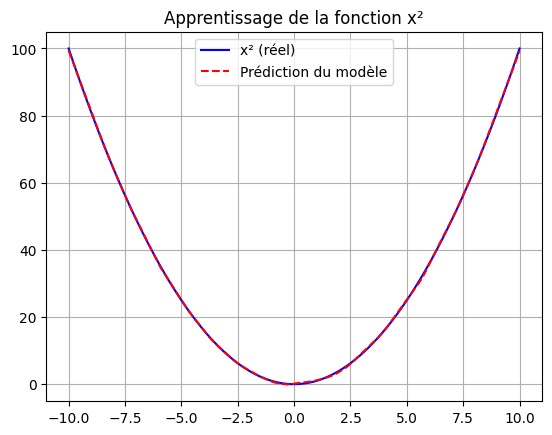

In [38]:
# Données d'entraînement : x ∈ [-10, 10]
x_train = torch.linspace(-10, 10, 100).view(-1, 1)
y_train = x_train ** 2

# Modèle : petit MLP (perceptron multilayer)
class SquareNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

model = SquareNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Entraînement
epochs = 500
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Test
model.eval()
x_test = torch.tensor([[2.0], [5.0], [-3.0]])
y_test_pred = model(x_test)

print("\nTests :")
for i, x_val in enumerate(x_test):
    pred = y_test_pred[i].item()
    true = (x_val ** 2).item()
    print(f"x = {x_val.item():.2f}, prédiction = {pred:.2f}, attendu = {true:.2f}")

# (Optionnel) Visualisation
with torch.no_grad():
    y_plot = model(x_train)
plt.plot(x_train.numpy(), y_train.numpy(), label='x² (réel)', color='blue')
plt.plot(x_train.numpy(), y_plot.numpy(), label='Prédiction du modèle', color='red', linestyle='--')
plt.legend()
plt.grid()
plt.title("Apprentissage de la fonction x²")
plt.show()